In [2]:
import math
ln2 = math.log(2)
def ln2over(t):
    return ln2/t
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import ode

In [3]:
# Thanks to http://stackoverflow.com/questions/2891790/pretty-printing-of-numpy-array
import contextlib
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

### Original data:
<img src=201502_plotting/method3_plot.png>

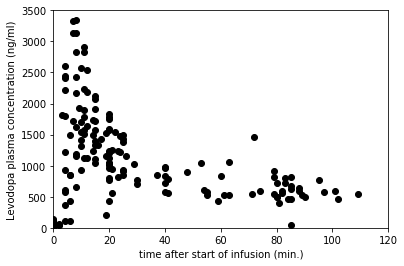

In [4]:
import csv
with open('Cp_estimation_20150304.csv', 'rb') as datafile:
    data  = np.genfromtxt(datafile, delimiter=",", usecols=range(0,7), names=True)  # imports as floats
    # the file has 7 blank rows at the end ...
    data = data[:-7]
data_times=data['new_minutes']
data_concs=data['LD']

%matplotlib inline
plt.scatter(data_times,data_concs,color='black')
plt.axis((0,120,0,3500))
plt.xlabel('time after start of infusion (min.)')  # ,fontsize=16
plt.ylabel('Levodopa plasma concentration (ng/ml)')
plt.show()

In [5]:
glob_interval_end = np.asarray([2.5, 6.5, 10.0, 12.5, 17.5, 22.5, 27.5, 35, 45, 70, 90, 120])
# create a list of arrays with points selected from data, with one array for each interval\n",
num_globs = glob_interval_end.size
globtime  = []
globconc  = []
globsize  = np.zeros([num_globs],int)
globmeant = np.zeros([num_globs])
globmeanc = np.zeros([num_globs])
globsdt = np.zeros([num_globs])
globsdc = np.zeros([num_globs])

DEBUG = True
start = -.001
for i in range(num_globs):
    end = glob_interval_end[i]
    items = np.logical_and(data_times > start,data_times <=end)
    globtime.append(data_times[np.nonzero(items)])  # this array is now globtime[i]
    globconc.append(data_concs[np.nonzero(items)])
    globsize[i]  = globtime[i].size
    globmeant[i] = np.mean(globtime[i])
    globmeanc[i] = np.mean(globconc[i])
    globsdt[i] = np.std(globtime[i])
    globsdc[i] = np.std(globconc[i])
    if DEBUG and i==2:
        print('interval i={0}, start time = {1}, end time = {2}, globsize[{0}]={3}'.\
              format(i,start,end,globsize[i]))
        # print(items)
        print(globtime[i])
        print(globconc[i])
        print('mean time in this interval: {0:.2f}; mean conc in this interval: {1:.2f}'.\
              format(globmeant[i], globmeanc[i]))
    start = end

interval i=2, start time = 6.5, end time = 10.0, globsize[2]=19
[  8.   7.   8.   8.   8.   8.   8.   7.   9.  10.   8.   7.  10.   8.  10.
   8.  10.  10.  10.]
[ 2165.  3130.  1185.  2420.  3141.  2830.  1627.  1722.  1924.  1698.
  3348.  3331.  2565.  1153.  1320.   664.   930.  1409.  1541.]
mean time in this interval: 8.53; mean conc in this interval: 2005.42


time:      0.4,    4.5,    8.5,   11.3,   15.0,   20.1,   24.5,   29.7,   39.9,   57.1,   82.0,  100.8
[LD]:     54.8, 1226.7, 2005.4, 1945.3, 1538.4, 1150.9, 1171.4,  828.7,  779.6,  702.1,  624.2,  589.8
S.D.:     40.3,  824.7,  828.0,  576.5,  324.5,  429.3,  242.9,  138.1,  146.2,  219.9,  244.5,  101.7
N   :       17,     17,     19,     12,     14,     22,     11,      3,      8,     10,     24,      5


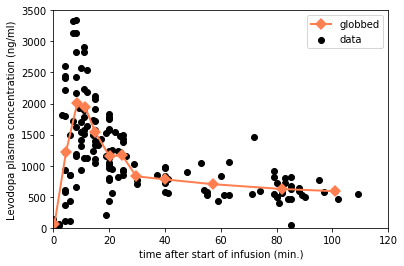

In [6]:
# First plot the real observed data.
plt.scatter(data_times,data_concs,color='black',label='data')
plt.axis((0,120,0,3500))
plt.xlabel('time after start of infusion (min.)') 
plt.ylabel('Levodopa plasma concentration (ng/ml)')
# plot the globbed points
plt.plot(globmeant,globmeanc,'coral',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='globbed') 
    # marker=(8,2,0),marker='D',marker='o',markeredgecolor='lime',
    # http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

plt.legend(loc='upper right')
printstringend = 11*'{:7.1f},'+'{:7.1f}'
print('time:  '+printstringend.format(*globmeant))
print('[LD]:  '+printstringend.format(*globmeanc))
print('S.D.:  '+printstringend.format(*globsdc))
printstringend = 11*'{:7d},'+'{:7d}'
print('N   :  '+printstringend.format(*globsize))
plt.show()

**The peak "glob" is probably a little lower than optimal because:**
1. some subjects have samples at (say) 6, 8 and 10 minutes, but of course only one of those is the peak for that subject, so including all 3 measures underestimates the peak;
2. some subjects have samples at (say) 8, 10 and 12 minutes, and the peak may occur at 12 minutes, outside the time limit for this glob.

For a better estimation of the peak time and concentration across subjects, based on each subject's peak in the 0 to 20-minute interval, see `Cp_estimation_20150304_20160806.xlsx` in `Box > Black_Lab\projects\PD\hysteresis_phMRI`. There, **mean Cp(0) = 56.21** (range 0-147, SD 45.74, N=14), **mean peak time = 9.0 (range 7-12**, SD 1.66, N=14), and **mean peak Cp = 2237.93** (range 1131-3348, SD 794.3, N=14).

Also, I may as well combine the 6th & 7th points above.

**So let's try that again.**

In [60]:
glob_interval_end = np.asarray([2.5, 6.5, 12.5, 17.5, 27.5, 35, 45, 70, 90, 120])
# create a list of arrays with points selected from data, with one array for each interval\n",
num_globs = glob_interval_end.size
globtime  = []
globconc  = []
globsize  = np.zeros([num_globs],int)
globmeant = np.zeros([num_globs])
globmeanc = np.zeros([num_globs])
globsdt = np.zeros([num_globs])
globsdc = np.zeros([num_globs])

DEBUG = True
start = -.001
for i in range(num_globs):
    end = glob_interval_end[i]
    items = np.logical_and(data_times > start,data_times <=end)
    globtime.append(data_times[np.nonzero(items)])  # this array is now globtime[i]
    globconc.append(data_concs[np.nonzero(items)])
    globsize[i]  = globtime[i].size
    globmeant[i] = np.mean(globtime[i])
    globmeanc[i] = np.mean(globconc[i])
    globsdt[i] = np.std(globtime[i])
    globsdc[i] = np.std(globconc[i])
    if i==2:
        globsize[i] = 14
        globmeant[i] = 9.0
        globmeanc[i] = 2237.93
        globsdt[i] = 1.66
        globsdc[i] = 794.3
        if DEBUG:
            print('interval i={0}, start time = {1}, end time = {2}, globsize[{0}]={3}'.\
                  format(i,start,end,globsize[i]))
            # print(items)
            print(globtime[i])
            print(globconc[i])
            print('  actual mean time in this interval: {0:.2f} +- {1:.2f}; mean conc in this interval: {2:.2f} +- {3:.2f}'.\
                  format(np.mean(globtime[i]),np.std(globtime[i]), np.mean(globconc[i]), np.std(globconc[i])))
            print('reported mean time in this interval: {0:.2f} +- {1:.2f}; mean conc in this interval: {2:.2f} +- {3:.2f}'.\
                  format(globmeant[i], globsdt[i], globmeanc[i], globsdc[i]))
    start = end

interval i=2, start time = 6.5, end time = 12.5, globsize[2]=14
[  8.   7.  11.   8.   8.  11.   8.  11.   8.  12.   8.  11.   7.   9.  10.
  11.   8.  12.   7.  10.   8.  10.  11.  12.   8.  10.  11.  12.  10.  11.
  10.]
[ 2165.  3130.  2911.  1185.  2420.  2236.  3141.  2823.  2830.  2186.
  1627.  1784.  1722.  1924.  1698.  1575.  3348.  2536.  3331.  2565.
  1153.  1320.  1891.  1643.   664.   930.  1118.  1131.  1409.  1510.
  1541.]
  actual mean time in this interval: 9.61 +- 1.64; mean conc in this interval: 1982.16 +- 741.43
reported mean time in this interval: 9.00 +- 1.66; mean conc in this interval: 2237.93 +- 794.30


time:      0.4,    4.5,    9.0,   15.0,   21.6,   29.7,   39.9,   57.1,   82.0,  100.8
[LD]:     54.8, 1226.7, 2237.9, 1538.4, 1157.7,  828.7,  779.6,  702.1,  624.2,  589.8
S.D.:     40.3,  824.7,  794.3,  324.5,  377.6,  138.1,  146.2,  219.9,  244.5,  101.7
N   :       17,     17,     14,     14,     33,      3,      8,     10,     24,      5


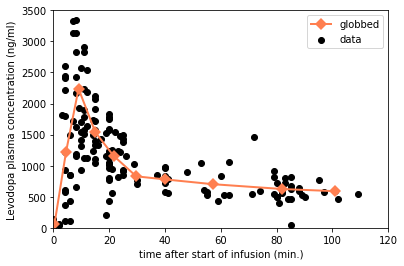

In [61]:
# Re-plot the real observed data with the New, Improved "globbed" data:
plt.scatter(data_times,data_concs,color='black',label='data')
plt.axis((0,120,0,3500))
plt.xlabel('time after start of infusion (min.)') 
plt.ylabel('Levodopa plasma concentration (ng/ml)')
# plot the globbed points
plt.plot(globmeant,globmeanc,'coral',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='globbed') 
    # marker=(8,2,0),marker='D',marker='o',markeredgecolor='lime',
    # http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

plt.legend(loc='upper right')
printstringend = (num_globs-1)*'{:7.1f},'+'{:7.1f}'
print('time:  '+printstringend.format(*globmeant))
print('[LD]:  '+printstringend.format(*globmeanc))
print('S.D.:  '+printstringend.format(*globsdc))
printstringend = (num_globs-1)*'{:7d},'+'{:7d}'
print('N   :  '+printstringend.format(*globsize))
plt.show()

But the true peak Cp has to be at or after the end of the loading dose, though (10 min.), so **one more tweak.** Let's extrapolate to a peak at 10 minutes. The first 3 points are nearly collinear (R=0.998), and the best fit line through them includes (10,2532.92). But, sigh, 2238 was already the best choice peak. Oh well, arbitrary but reasonable choice here.

In [66]:
i=2
globsize[i] = 14
globmeant[i] = 10 # was (9, 2237.9)
globmeanc[i] = 2532.92 # was (9, 2237.9)
globsdt[i] = 1
globsdc[i] = 794.3

time:      0.4,    4.5,   10.0,   15.0,   21.6,   29.7,   39.9,   57.1,   82.0,  100.8
[LD]:     54.8, 1226.7, 2532.9, 1538.4, 1157.7,  828.7,  779.6,  702.1,  624.2,  589.8
S.D.:     40.3,  824.7,  794.3,  324.5,  377.6,  138.1,  146.2,  219.9,  244.5,  101.7
N   :       17,     17,     14,     14,     33,      3,      8,     10,     24,      5


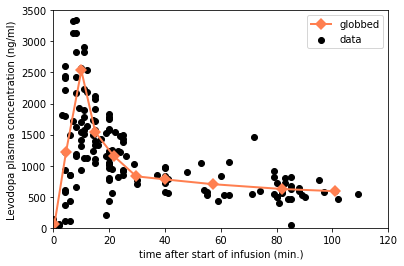

In [67]:
# Re-plot the real observed data with the Newer, Improved-er "globbed" data:
plt.scatter(data_times,data_concs,color='black',label='data')
plt.axis((0,120,0,3500))
plt.xlabel('time after start of infusion (min.)') 
plt.ylabel('Levodopa plasma concentration (ng/ml)')
# plot the globbed points
plt.plot(globmeant,globmeanc,'coral',
         markersize=8,marker=('D'),markeredgewidth=0,linewidth=2.0,
         label='globbed') 
    # marker=(8,2,0),marker='D',marker='o',markeredgecolor='lime',
    # http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

plt.legend(loc='upper right')
printstringend = (num_globs-1)*'{:7.1f},'+'{:7.1f}'
print('time:  '+printstringend.format(*globmeant))
print('[LD]:  '+printstringend.format(*globmeanc))
print('S.D.:  '+printstringend.format(*globsdc))
printstringend = (num_globs-1)*'{:7d},'+'{:7d}'
print('N   :  '+printstringend.format(*globsize))
plt.show()

Anyway. Looks science-y. :)

In [68]:
debug = False
makenewpoints = True

if debug:
    sample_n = 3
else:
    sample_n = 100

# c_samples  (for \"concentration samples\")
#   = 2D array, sample_n rows, each row with num_globs entries, each 
#   entry chosen at random from the corresponding glob interval.

if makenewpoints:
    points = np.empty(sample_n,dtype=np.uint16)
    t_samples = np.empty([sample_n,num_globs])
    c_samples = np.empty([sample_n,num_globs])
    if debug:
        print(points)
        print(t_samples)
    for i in range(num_globs):
        # Figure out which point to select from this glob of points:
        points = np.random.randint(globtime[i].size, size=sample_n)
    if debug:
        print(globtime[i].size)
        print(points)
        for x in points:
            print(globtime[3][x])
        temp = []
        for x in points:
            temp.append(globtime[3][x])
        temp

In [69]:
if makenewpoints:
    for i in range(num_globs):
        # Figure out which point to select from this glob of points:
        points = np.random.randint(globtime[i].size, size=sample_n)
        if debug:
            print(globtime[i].size,'\t',points)
        for a in range(sample_n):
            t_samples[a,i] = globtime[i][points[a]]  # take points in this glob in the random order just defined
            c_samples[a,i] = globconc[i][points[a]]

# If I wanted to select time and conc. independent of each other, I could do this:
#    t_samples[:,i] = np.random.choice(globtime[i],size=sample_n,replace=True)
#    c_samples[:,i] = np.random.choice(globconc[i],size=sample_n,replace=True)

In [70]:
print(t_samples[:3,:])
print(c_samples[:3,:])

[[   2.    6.    8.   14.   23.   30.   40.   55.   85.   97.]
 [   2.    4.   12.   14.   19.   30.   41.   63.   80.  109.]
 [   0.    4.    9.   15.   25.   30.   40.   63.   82.  102.]]
[[   38.   846.  2420.  1240.   813.   703.   577.   520.   456.   575.]
 [   38.   366.  2536.  1498.  1519.   703.   555.   525.   490.   541.]
 [    0.  1799.  1924.  1394.  1490.   762.   577.  1054.   555.   468.]]


In [73]:
def plot_data_and_samples(n=sample_n,savepng=False):
    plt.axis((0,112,0,3500))
    plt.xlabel('time after start of infusion (min.)') 
    plt.ylabel('Levodopa plasma concentration (ng/ml)')
    # plot the samples
    mylabel = 'sample curves'
    for i in range(n):
        plt.plot(t_samples[i],c_samples[i],
                 color='lightgrey',marker=None,linewidth=1.0, 
                 label=mylabel)
        mylabel = '_nolegend_'  # => label is defined only for i==0
    # plot the real data
    plt.scatter(data_times,data_concs,color='black',label='data')
    legend = plt.legend(loc='upper right')
    # ,frameon=False
    # framealpha=0.3,
    legend.get_frame().set_facecolor('none')
    # '#FFCC77'
    if savepng:
        plt.savefig('samples2.png', dpi=600, transparent=True)
    plt.show()

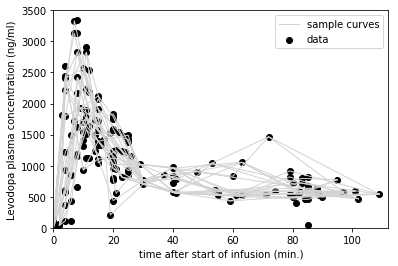

In [78]:
plot_data_and_samples(25,savepng=True)

## Definitions

We're defining $C_p(t)$ (in 2 parts, to fit the 2 infusion rates) based on differential equations for a 2-compartment model.
* Time $t$ is in minutes. Domain: $t\ge 0$.
* Compartments
    - Compartment 1 = plasma
    - Compartment 2 = rest of the body accessible to plasma
    - $V_i$ = volume of compartment $i$, here assumed to be constant. $VOD_{ss} = V_1 + V_2$.
* Drug mass: $X_i(t)$ = quantity of levodopa in compartment $i$ at time $t$
* Rate constants:
    - $k_1$ = distribution from plasma; $k_2$ = return to plasma
    - $k_0$ = elimination from body
        + Here = in [https://www.boomer.org/c/p4/c19/c1902.html](https://web.archive.org/web/20151212112528/https://www.boomer.org/c/p4/c19/c1902.html)
        + $k_0$ = $k_{el}$
        + $k_1$ = $k_{12}$
        + $k_2$ = $k_{21}$
    - Thus (approximately), $\alpha, \beta = \frac{S \pm \sqrt{S^2 - 4P}}{2}$, where $S=k_0+k_1+k_2$ and $P=k_0k_2$.
    - [This page](https://www.boomer.org/c/p4/c19/c1903.html) tells how to go from $\alpha, \beta, A$ and $B$ to $k_0, k_1$, and $k_2$. 

* Infusion rates:
    - $R_L$ (loading rate) for $t\le t_L$ (the length of the loading dose)
    - $R_M$ (maintenance rate) for $t> t_L$
    - See [Black et al. 2003](https://www.ncbi.nlm.nih.gov/pubmed/12865145) for the actual values of $R_L$ and $R_M$ depending on age and body mass. For use here, they should be given in **ng**/min rather than mg/min.

## Parameter reduction

### At $t=\infty$, equilibrium has been reached.

Thus (1) the rate of drug entering the body (the maintenance infusion rate $R_M$) = rate of drug leaving the body, or:

$$R_M = k_0 X_1(\infty)$$

$$\implies X_1(\infty) = \frac{R_M}{k_0}$$

(2) The equilibrium also applies to the transfer between compartments 1 and 2:

$$k_1X_1(\infty) = k_2X_2(\infty)$$

$$\implies X_2(\infty) = \frac{k_1}{k_2}X_1(\infty)$$

$$\hphantom{\implies X_2(\infty) }= \frac{k_1R_M}{k_2k_0}$$

In previous notebooks I used the symbol $C_{inf}$. 

$$C_{inf} = \frac{X_1(\infty)}{V_1} = \frac{X_2(\infty)}{V_2}$$

$$\hphantom{C_{inf} }= \frac{R_M}{k_0V_1} = \frac{k_1R_M}{k_2k_0V_2}$$

Therefore

$$V_2 = \frac{k_1}{k_2} V_1$$

Remember all of this **assumes** that the $k_{ij}$s are constant.

## All that leads to this pair of differential equations:

For $t < t_L :$

$$ X_1'(t) = R_L - (k_0+k_1)X_1 + k_2X_2 $$

$$ X_2'(t) = \hphantom{R_L - (k_0+)} k_1X_1 - k_2X_2 $$

We will stipulate that $X_1(0)\,/\,V_1 = X_2(0)\,/\,V_2 = C_0$, where $C_0$ is the venous drug concentration at the beginning of the study ("left over" from the previous night's doses, and probably around 55ng/ml according to the 2003 study). We **assume** that all these concentrations are essentially in equilibrium at the start of the infusion. That's reasonable given the study design with patients coming in in the "practical off" state. In any case, the peripheral venous concentration at the start of the infusion is our best estimate of the initial drug concentration in either compartment. 

In other words, initial conditions are $X_1(0) = V_1 C_0$ and $X_2(0) = V_2 C_0$. 

For $t \ge t_L$ the equations are identical except that $R_L$ is replaced by $R_M$, and the initial conditions (now meaning at $t= t_L$) are determined by $X_1(t_L)$ and $X_2(t_L)$ from the equations above for $t < t_L$.

### Circulation delay

The original time:concentration data from the 2003 paper take a minute or two to "take off":

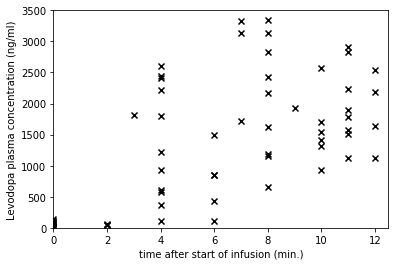

In [12]:
# figure = plt.figure(figsize=(4,7))
plt.scatter(data_times,data_concs,marker='x',color='black')
plt.axis((0,12.5,0,3500))
plt.xlabel('time after start of infusion (min.)')  # ,fontsize=16
plt.ylabel('Levodopa plasma concentration (ng/ml)')
plt.show()

This observation, plus biological necessity, suggests **we should also include** in the final model the delay from infusion in one upper extremity vein to the right heart, to the lungs, to the left heart, to the arteries, to a vein on the other side of the body, where we sample the blood. This could be modeled in various ways, but it is probably OK to **assume** a simple fixed delay, *i.e.* essentially a change of axis in the differential equations above from $t$ to $t-t_s$ (for time shift), though we could instead model it as another, mixing "compartment." Our PET experience in older adults suggests that the delay from a venous bolus infusion to its appearance in the cerebral arteries is probably 15-40 seconds. So $t_s$, which also includes return from the capillaries to the vein where we sample, is probably in the range 15-60 seconds. The graph suggests it could possibly be 2 minutes or more, but note that there are few data points before $t=4$ min, so take that 2+ minute thing with a grain of salt.

## OK. Closed-form solutions from Maxima go here.
Generic solution to
$$ 
x_1^\prime(t) = -k_0 x_1(t) -k_1 x_1(t) + k_2 x_2(t) + R \\
x_2^\prime(t) = \hphantom{-k_0 x_1(t) }k_1 x_1(t) - k_2 x_2(t) \\
$$
See 20170922_pk.wxmx for derivation. The idea is to use $R=R_L$ for $0\le t\le t_L$ and $R=R_M$ for $t>t_L$. Initial conditions for the loading phase are $x_1(0)/V_1=x_2(0)/V_2=C_0$. Initial conditions for the maintenance phase ($t>t_L$) come from $x_1(t_L)$ and $x_2(t_L)$ using the solution for the loading phase. The parameters `x10` and `x20` in the next cell mean $x_1(0)$ and $x_2(0)$ respectively. `ts` is for "time shift."

In [13]:
def generic_x1(t,k0,k1,k2,R,x10,x20,ts):
    '''Returns a closed-form solution to the problem in the cell above. 
    The return value and the parameter t are numpy arrays. Other parameters are real numbers.
    '''
    u = t-ts
    rad = (k0+k1+k2)**2 - 4*k0*k2
    if rad > 0 :
        sqrad = math.sqrt(rad)
        return np.exp(-u*(k0+k1+k2)/2)*( \
                    np.sinh(u*sqrad/2)* ((k0-k1-k2)*R/k0 + x10*(k2-k1-k0) + 2*x20*k2)/sqrad \
                  + np.cosh(u*sqrad/2)*(x10-R/k0) ) + R/k0 
    elif rad < 0 :
        sqrad = math.sqrt(-rad)
        return np.exp(-u*(k0+k1+k2)/2)*( \
                    np.sin(u*sqrad/2)*(2*k2*x20+x10*(k2-k1-k0)+R*(k0-k1-k2)/k0)/sqrad \
                  + np.cos(u*sqrad/2)*(x10-R/k0) ) + R/k0 
    else:  # rad = 0
        return np.exp(-u*(k0+k1+k2)/2)*( u*(2*k2*x20+x10*(k2-k1-k0)+R*(k0-k1-k2)/k0)/2+x10-R/k0 ) + R/k0

def generic_x2(t,k0,k1,k2,R,x10,x20,ts):
    '''Returns a closed-form solution to the problem in the cell above. 
    The return value and the parameter t are numpy arrays. Other parameters are real numbers.
    '''
    u = t-ts
    rad = (k0+k1+k2)**2 - 4*k0*k2
    if rad > 0 :
        sqrad = math.sqrt(rad)
        return  np.exp(-u*(k0+k1+k2)/2)*( \
                    np.sinh(u*sqrad/2)*(x20*(k0+k1-k2)+2*k1*x10-R*k1*(k0+k1+k2)/(k0*k2))/sqrad \
                  + np.cosh(u*sqrad/2)*(x20-R*k1/(k0*k2)) ) + R*k1/(k0*k2)
    elif rad < 0 :
        sqrad = math.sqrt(-rad)
        return np.exp(-u*(k0+k1+k2)/2)*( \
                    np.sin(u*sqrad/2)*(2*x10*k1+x20*(k0+k1-k2)-R*k1*(k0+k1+k2)/(k0*k2))/sqrad \
                  + np.cos(u*sqrad/2)*(x20-R*k1/(k0*k2)) ) + R*k1/(k0*k2) 
    else:  # rad = 0
        return np.exp(-u*(k0+k1+k2)/2)*( \
                    u*(2*k1*x10 +(k0+k1-k2)*x20-R*k1*(k0+k1+k2)/(k0*k2))/2 + x20-R*k1/(k0*k2) ) \
                    + R*k1/(k0*k2)

In [14]:
def c1(t,k0,k1,k2,V1,V2,ts,C0,RL,RM,tL=10.0):
    '''Returns a numpy array with C1(t), based on the generic solution above.
    The time shift ts can cause values for c1(t), t<ts, to be < C0 (or even < 0). Hence the
        last line.
    Note x1(t) is divided by V1, in the penultimate line, to return concentration not mass.
    '''
    def x1_load(t):
        return generic_x1(t,k0,k1,k2,RL,C0*V1,C0*V2,ts)
    def x2_load(t): 
        return generic_x2(t,k0,k1,k2,RL,C0*V1,C0*V2,ts)
    def x1_maint(t):
        return generic_x1(t-tL,k0,k1,k2,RM,x1_load(tL+ts),x2_load(tL+ts),ts)
    temp = np.where(t<=tL+ts,x1_load(t),x1_maint(t))/V1
    return np.where(temp<C0, C0, temp)

### The function that `curve_fit` sees can't have fixed parameters. Create a wrapper function for `c1(t)` that has only parameters to be estimated.

In [15]:
mass_known = 70 # kg
age_known = 60 # yr
C0_known = 55.4  # ng/ml
tL_known = 10  # min.
RL_known = 0.6426 * mass_known * 1e6 / tL_known # ng/min
RM_known = 2.882E-5 * mass_known * (140-age_known) * 1e6  # ng/min
print('RL_known (mg/min.) = {0:.4f}'.format(RL_known/1e6))
print('RM_known (mg/min.) = {0:.4f}'.format(RM_known/1e6))

RL_known (mg/min.) = 4.4982
RM_known (mg/min.) = 0.1614


In [16]:
def c1_for_estimation(t,k0,k1,k2,V1,V2,ts):
    return c1(t,k0,k1,k2,V1,V2,ts,C0_known,RL_known,RM_known,tL_known)

### Set bounds for the `curve_fit` routine to use in estimating PK parameters:

In [17]:
# Plasma volume: PMID: 1110403
v1_est = 3000*mass_known/70  # units: ml
# VODss estimate from http://www.frontiersin.org/files/Articles/168565/fphar-06-00307-HTML/image_m/fphar-06-00307-t002.jpg
# is 1.18 L/kg. Hence:
v2_est = 1.18e3*mass_known - v1_est  # units: ml
# Elimination half-life is about 1.5 hr (http://www.frontiersin.org/files/Articles/168565/fphar-06-00307-HTML/image_m/fphar-06-00307-t002.jpg)
# From the same source, t1/2alpha is about 0.14 hr.
# From equilibrium, k2 is approx. k1*V1/V2. (See \"parameter reduction\", above.)
k0_est = ln2over(1.5*60)   # 0.0077 units: 1/min.
k1_est = ln2over(0.14*60)  # 0.0825  units: 1/min.
k2_est = k1_est*v1_est/v2_est  # 0.0031 units: 1/min.
# Better starting guesses, from hand fit at Cp_estimation_20150305_20170925.xlsx
k0_est = 0.0684  # units: 1/min.
k1_est = 0.042  # units: 1/min.
k2_est = 0.013   # units: 1/min.
# From PET experience (see above):
ts_est = 20/60.  # units: min.

# def c1_for_estimation(t,k0,k1,k2,V1,V2,ts):
myp0 =  (k0_est, k1_est, k2_est, v1_est, v2_est, ts_est)

# See entries above in this cell, and the same spreadsheet, for some of these limits.
# VODss bounds come from the Siddiqi et al table linked above: next-lowest and next-highest values.
mybounds = ((0.0100, 0.0279, 0.0100,  800*v1_est/3000., 0.26e3*mass_known-v1_est,   5/60.), 
            (0.0800, 0.4000, 0.1500, 4600*v1_est/3000., 2.63e3*mass_known-v1_est, 120/60.))

In [18]:
cp_params = [0.0799, 0.212, 0.0241, 5200, 45822, 0.393]
for x in range(0,10,1):
    print('{0:>4.1f}\t{1:>7.1f}'.format(x/10.,np.asscalar(c1_for_estimation(x/10., *cp_params))))

 0.0	   55.4
 0.1	   55.4
 0.2	   55.4
 0.3	   55.4
 0.4	   61.4
 0.5	  146.1
 0.6	  228.3
 0.7	  308.1
 0.8	  385.7
 0.9	  461.1


In [19]:
def print_PK_ests(k0,k1,k2,v1,v2,ts, head=None, tail=None):
    if head==None:
        head = '  k0\t  k1\t  k2\t v1\t  v2\t ts'
    if head=='':
        pass
    else:
        print(head)
    print('{0:.4f}\t{1:.3f}\t{2:6.4f}\t{3:4.0f}\t{4:6.0f}\t{5:5.3f}'\
          .format(k0,k1,k2,v1,v2,ts))
    if tail==None:
        # See above link to boomer.org for the following
        S = k0+k1+k2
        P = k0*k2
        beta  = (S-math.sqrt(S*S-4*P))/2
        alpha = (S+math.sqrt(S*S-4*P))/2
        print('\tthalf approx. = {0:.0f} min.'.format(ln2over(beta)))
        print('\tthalfalpha approx. = {0:.1f} min.'.format(ln2over(alpha)))
    elif tail=='':
        pass
    else:
        print(tail)

print('rough guesses for PK parameters:')
print_PK_ests(*myp0)

print('\nbounds for curve_fit routine are set as follows:')
print_PK_ests(*mybounds[0])
print_PK_ests(*mybounds[1],head='')

rough guesses for PK parameters:
  k0	  k1	  k2	 v1	  v2	 ts
0.0684	0.042	0.0130	3000	 79600	0.333
	thalf approx. = 90 min.
	thalfalpha approx. = 6.0 min.

bounds for curve_fit routine are set as follows:
  k0	  k1	  k2	 v1	  v2	 ts
0.0100	0.028	0.0100	 800	 15200	0.083
	thalf approx. = 317 min.
	thalfalpha approx. = 15.2 min.
0.0800	0.400	0.1500	4600	181100	2.000
	thalf approx. = 35 min.
	thalfalpha approx. = 1.1 min.


### Those estimates seem acceptable.

In [20]:
def plot_one_sample_with_data_and_fit(n,k0,k1,k2,v1,v2,ts,savepng=False,with_data=True):
    plt.axis((0,112,0,3600))
    plt.xlabel('time after start of infusion (min.)')
    plt.ylabel('Levodopa plasma concentration (ng/ml)')
    plt.plot(t_samples[n],c_samples[n],
        color='black',marker=None,linewidth=2.0, 
        label='data sample #'+str(n))
    tees = np.linspace(0,120,121)
    plt.plot(tees,c1_for_estimation(tees,k0,k1,k2,v1,v2,ts),'r', label='C1, fit to #'+str(n))
    if with_data:
        # plot the real data
        plt.scatter(data_times,data_concs,color='black',facecolors='none',label='data')
    legend = plt.legend(loc='upper right')
    legend.get_frame().set_facecolor('none')
    if savepng:
        plt.savefig('1samplefit.png', dpi=600, transparent=True)
    plt.show()

  k0	  k1	  k2	 v1	  v2	 ts
0.0800	0.320	0.0472	4600	 15200	1.746
	thalf approx. = 81 min.
	thalfalpha approx. = 1.6 min.


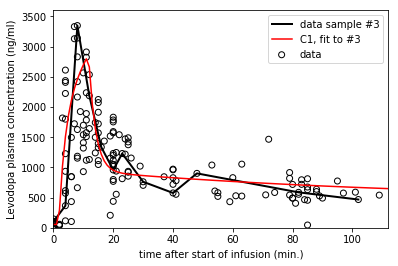

In [26]:
sample = 3
#  c1_for_estimation(t,k0,k1,k2,V1,V2,ts)
popt, pcov = curve_fit(c1_for_estimation, t_samples[sample], c_samples[sample], \
                       p0=myp0, bounds=mybounds)
print_PK_ests(*popt)
# See above, near link to boomer.org, for following:
plot_one_sample_with_data_and_fit(sample,*popt,with_data=True,savepng=False)

## Now that's more like it!!!

Still rather imperfect. V1 is constrained by the limits, but it pretty much can't be higher with a 2-compartment model in which V1 represents plasma volume. And k0, k1, v2 are also constrained. Probably the model fits the data imperfectly--for one, the model always peaks at t=10 min.+ts--which also makes sense given the drug infusion--but the data samples don't. Oh well.

Anyway. Now finally for what we came for.

In [27]:
iterations = sample_n
answers = np.zeros((iterations,len(myp0))) 
for i in range(iterations):
    popt, pcov = curve_fit(c1_for_estimation, t_samples[i], c_samples[i], \
                           p0=myp0, bounds=mybounds)
    answers[i] = popt

### Each `answers[i]` consists of the parameters `[k0, k1, k2, v1, v2, ts]` for sample `i` from the PK data.  
    i in range(sample_n)

### For `Ce0`, 
For each sample `i`, we can use the first Cp value from the collection of points used for that sample, namely `c_samples[i,0]`.

In [28]:
print('\t  k0\t  k1\t  k2\t v1\t  v2\t  ts')
print("mean\t{0:.4f}\t{1:.3f}\t{2:.4f}\t{3:>4.0f}\t{4:>6.0f}\t {5:.3f}".\
          format(*np.mean(answers,axis=0)))
print("S.D.\t{0:.4f}\t{1:.3f}\t{2:.4f}\t{3:>4.0f}\t{4:>6.0f}\t {5:.3f}".\
          format(*np.std( answers,axis=0)))
print("CoV\t", end=' ')
for cov in np.std(answers,axis=0)/np.mean(answers,axis=0):   # elementwise division
    print('{0:.1%}'.format(cov), end='\t') 

	  k0	  k1	  k2	 v1	  v2	  ts
mean	0.0800	0.388	0.0564	4561	 30968	 1.200
S.D.	0.0000	0.037	0.0135	 160	 46927	 0.839
CoV	 0.0%	9.4%	24.0%	3.5%	151.5%	70.0%	

Yup, k0 and v1 are pretty much identical for all samples. Less so k1.

### Save parameter files for k0, k1, k2, v1, v2, ts and ce0 in 4dfp image format.

In [29]:
with open('k0.4dfp.img','wb') as f:
    answers[:,0].astype(np.float32).tofile(f)
with open('k1.4dfp.img','wb') as f:
    answers[:,1].astype(np.float32).tofile(f)
with open('k2.4dfp.img','wb') as f:
    answers[:,2].astype(np.float32).tofile(f)
with open('v1.4dfp.img','wb') as f:
    answers[:,3].astype(np.float32).tofile(f)
with open('v2.4dfp.img','wb') as f:
    answers[:,4].astype(np.float32).tofile(f)
with open('ts.4dfp.img','wb') as f:
    answers[:,5].astype(np.float32).tofile(f)
with open('ce0.4dfp.img','wb') as f:
    c_samples[:,0].astype(np.float32).tofile(f)

### Now let's try it with all the data at once.

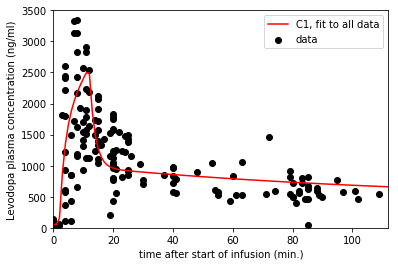

  k0	  k1	  k2	 v1	  v2	 ts
0.0800	0.400	0.0584	4600	 15200	1.896
	thalf approx. = 79 min.
	thalfalpha approx. = 1.3 min.
Cpeak = 2578ng/ml.


In [30]:
popt, pcov = curve_fit(c1_for_estimation, data_times, data_concs, \
                       p0=myp0, bounds=mybounds)
starttime = 0
endtime=112
plt.axis((starttime,endtime,0,3500))
plt.xlabel('time after start of infusion (min.)')
plt.ylabel('Levodopa plasma concentration (ng/ml)')
tees = np.linspace(starttime,endtime,1+endtime)
plt.plot(tees,c1_for_estimation(tees, *popt),'r', label='C1, fit to all data')
# plot the real data
plt.scatter(data_times,data_concs,color='black',label='data')
legend = plt.legend(loc='upper right')
legend.get_frame().set_facecolor('none')
#plt.savefig('all_data_fit.png', dpi=600, transparent=True)
plt.show()
print_PK_ests(*popt)
ts_here=popt[-1]
print('Cpeak = {0:.0f}ng/ml.'.format(np.asscalar(c1_for_estimation(tL_known+ts_here, *popt))))

### Hey! That's pretty good.

Of course, the fit overestimates most of the data for $t < 10$ min. and for $t > 30$ min. As above, k0, k1, v1 and v2 are all pegged to one end of the bounds I provided. The best estimates for distribution and elimination half-lives are 6 and 90 minutes, respectively. Anyway, probably good enough. I can use either these estimates or the mean of the 100 samples estimates. The latter will give a SD for the non-pegged estimates.

# Effect compartment modeling

[LD] in the effect compartment increases at a rate proportional to how much higher the concentration is in the central compartment (plasma). In other words, 

$$C_e'(t) = k_e (C_p(t)-C_e(t)) \ ,$$ 

where $k_e$ is the effect compartment rate constant.

In [31]:
def Ceprime(t, ce, ke, k0,k1,k2,v1,v2,ts):
    """Derivative with respect to t of Ce(t), or [LD] in the effect compartment.
    t is time as a scalar
    ke is the rate constant for the effect compartment, a.k.a. ke0.  
    Units: Ceprime(t) ng/ml/min, t min, ke 1/min, ce0 ng/ml.
    Requires c1_for_estimation(t,k0,k1,k2,V1,V2,ts) as defined above.
    """
    return ke*(c1_for_estimation(t, k0,k1,k2,v1,v2,ts)-ce)

### testing ...

In [32]:
cp_params = [0.0799, 0.212, 0.0241, 5200, 45822, 0.393]
t_limit = 300.0
dt = 1.0
ce0 = 55.4 # ng/ml
ke_test = ln2over(5) 
ke = ke_test
printstep = 50 # how often to print integration results

r = ode(Ceprime).set_integrator('dopri5', rtol=0.01, verbosity=1)
r.set_initial_value(ce0).set_f_params(ke, *cp_params)
print('  t\t    Cp\t    Ce')
print('====\t ======\t ======')
while r.successful() and r.t < t_limit:
    r.integrate(r.t+dt)
    if r.t % printstep == 0:
        print('{0:>4.0f}\t{1:>7.0f}\\t{2:>7.0f}'.format(\
            r.t, np.asscalar(c1_for_estimation(r.t, *cp_params)), np.asscalar(r.y)))
time = np.linspace(0,300,301)
temp = np.full(time.size,ce0,dtype=float)
i = 0
r.t = 0.0
while r.successful() and r.t < time[-1]:
    temp[i+1] = r.integrate(time[i+1])
    i += 1
temp[::printstep]

  t	    Cp	    Ce
====	 ======	 ======
  50	    576\t    597
 100	    526\t    532
 150	    489\t    494
 200	    462\t    466
 250	    442\t    445
 300	    428\t    430


array([  55.4       ,  597.67058146,  532.07706565,  493.69881071,
        465.58225174,  444.9766546 ,  429.87555975])

In [33]:
r = ode(Ceprime).set_integrator('dopri5', atol=1, rtol=0.001, max_step=10.0, verbosity=1)
# 'dopri5' = Runge-Kutta method of oreder (4)5, atol = absolute tolerance, rtol = relative tolerance
r.set_initial_value(ce0).set_f_params(ke, *cp_params)
r.t = 0.0
r.integrate(200.0)

array([ 465.58296527])

### working ...

In [34]:
def Ce_scalar(time, ke, k0,k1,k2,V1,V2,ts, ce0=55.4):
    """Ce(t), or levodopa concentration in the effect compartment.
    keyword argument: ce0 is the concentration in the effect compartment at time t=0, Ce(0).
    t is time in minutes (scalar)
    ke is the rate constant for the effect compartment, a.k.a. ke0.  
    Units: Ce(t) ng/ml, t min, ke 1/min, ce0 ng/ml.
    ce0 = Ce(0)=the baseline Cp in the \"practical off\" state (was 55.4ng/ml for 10 LD-treated 
        PD patients in Black et al. 2003)
    Ceprime uses c1_for_estimation(t,k0,k1,k2,V1,V2,ts) as defined above.
    """
    assert ke > 0, 'ke must be positive, but was given as {0}.'.format(ke)
    if float(ke)==0.0:  # If k is zero, Ce(t)==Ce(0) for all t>=0.
        return ce0
    # otherwise, ...
    r = ode(Ceprime).set_integrator('dopri5', atol=1, rtol=0.001, max_step=10.0, verbosity=1)
    # def Ceprime(t, ce, ke, k0,k1,k2,v1,v2,ts):   
    # (Ceprime is 'f' and ce is 'y' in the scipy.integrate.ode documentation)
    r.set_initial_value(ce0).set_f_params(ke, k0,k1,k2,V1,V2,ts)
    i = 0
    r.t = 0.0
    return r.integrate(time)

# time = np.linspace(0,300,301)
def Ce(time, ke, k0,k1,k2,V1,V2,ts, ce0=55.4):
    """Ce(t), or levodopa concentration in the effect compartment.
    keyword argument: ce0 is the concentration in the effect compartment at time t=0, Ce(0).
    t is a numpy array of time points
    ke is the rate constant for the effect compartment, a.k.a. ke0.  
    Units: Ce(t) ng/ml, t min, ke 1/min, ce0 ng/ml.
    ce0 = Ce(0)=the baseline Cp in the "practical off" state (was 55.4ng/ml for 10 LD-treated 
        PD patients in Black et al. 2003)
    Ceprime uses c1_for_estimation(t,k0,k1,k2,V1,V2,ts) as defined above.
    """
    assert ke > 0, 'ke must be positive, but was given as {0}.'.format(ke)
    temp = np.full(time.shape,ce0,dtype=float)
    if float(ke)==0.0:  # If k is zero, Ce(t)==Ce(0) for all t>=0.
        return temp
    # otherwise, ...
    r = ode(Ceprime).set_integrator('dopri5', rtol=0.01, verbosity=1)
    # def Ceprime(t, ce, ke, k0,k1,k2,v1,v2,ts):   
    # (Ceprime is 'f' and ce is 'y' in the scipy.integrate.ode documentation)
    r.set_initial_value(ce0).set_f_params(ke, k0,k1,k2,V1,V2,ts)
    i = 0
    r.t = 0.0
    while r.successful() and r.t < time[-1]:
        temp[i+1] = r.integrate(time[i+1])
        i += 1
    return temp

In [35]:
# def c1_for_estimation(t, k0,k1,k2,V1,V2,ts):
cp_params = [0.0799, 0.212, 0.0241, 5200, 45822, 0.393]

In [36]:
# def Ce_scalar(time, ke, k0,k1,k2,V1,V2,ts, ce0=55.4):
# def        Ce(time, ke, k0,k1,k2,V1,V2,ts, ce0=55.4):

def effect(t, k0, k1, k2, v1, v2, ts, ke, ec50, n, ce0=55.4):
    """E(Ce(t)), drug effect at time t, based on [LD] in effect compartment, using a sigmoid PD model.
    t is a numpy array of time points.
    ke is the rate constant ke, a.k.a. ke0.
    n is the Hill constant.
    Units: t min, Ce(t) ng/ml, k 1/min.
    Assumes that E(0) = 0 and Emax = 1.
    Assumes the Cp(t) modeled above based on a 2-compartment model and Fig. 3 from Black et al 2003. 
    Ce(0) = the baseline Cp in the "practical off" state, 55.4 for 10 LD-treated PD patients in ibid.
    """
    x = Ce(t, ke, k0,k1,k2,v1,v2,ts, ce0)
    return x**n/(x**n + ec50**n)
#        (or) use: A/(A+B) = 1/(1+(B/A))  (ec50 is positive and Ce is always positive _if_ Ce0 is)
#        return 1/(1+ec50**n/Ce(time, ke, k0,k1,k2,V1,V2,ts, ce0)**n)

In [37]:
# PK-PD parameters for Park. Dz. patients' tapping speed
# Contin et al 2001, Table 4
# 12-hour washout

stages = ['best','I','II','III','IV','worst'] 
thalfeqs = [277,133,78,28,20,5]
keqs = [ln2over(x) for x in thalfeqs]
ec50s = [100,200,290,600,940,1200]
hillns = [1,2,5,7,18,49]
# next line for info only
durations = [0.5,2.0,5.0,9.0,12.0,24.0] # duration of PD in years
# from effect_compartment_modeling_20141223.xlsx , 
# y = 0.0028x - 0.0021, R² = 0.8967 for all data from Contin et al 2001 and Harder & Bass 1998,
# when plotting disease duration in years against Keq in 1/min.
# When forcing y-intercept to be 0, the line is y = 0.0026x, R² = 0.8908.
#durations = [0.5, 2.0, 5.0, 10.0, 15.0, 25.0]
#keqs = [0.0028*x for x in durations]
#thalfeqs = [ln2over(x) for x in keqs]

print(['{:.3f}'.format(x) for x in keqs])

['0.003', '0.005', '0.009', '0.025', '0.035', '0.139']


In [38]:
# Times for ASL frame start, end & midpoint, in minutes, for a ~9'40\" ASL series
# (See Google sheet MPDP_ASL_timing)

frame1start = 7/60. # first frame starts about 7 sec. after hitting start
TR = 17/60.  # 17sec., in min. (one GRASE frame--effective TR for an ASL frame is twice that)
numframes = 18  # meaning ASL frames, so twice as many GRASE frames
aslstarts = np.fromiter((frame1start + 2*i*TR for i in range(numframes)), np.float)
aslendpts = aslstarts + 2*TR
aslmidpts = (aslstarts + aslendpts)/2
# Note: aslendpts[-1] = 10.32 min. So let's say it's 11'00\" between series, start to start.
# On average that's probably about what it will be.
# So for frame i, counting from 0, frames will start at 11*i + aslstarts.
seriesduration = 11 # minutes
# Times for ASL frame starts, in minutes, from the beginning to the end of the scan:
duration = 120 # minutes
numruns = duration // seriesduration
asl_start_all = np.concatenate([seriesduration*run + aslstarts for run in range(numruns)])
asl_endpt_all = np.concatenate([seriesduration*run + aslendpts for run in range(numruns)])
asl_midpt_all = np.concatenate([seriesduration*run + aslmidpts for run in range(numruns)])
print('number of frames (time points) in asl_midpt_all: ', len(asl_midpt_all))
print(asl_midpt_all[:4])
print(asl_midpt_all[-4:])

number of frames (time points) in asl_midpt_all:  180
[ 0.4         0.96666667  1.53333333  2.1       ]
[ 107.33333333  107.9         108.46666667  109.03333333]


## Resampling effect curves to ASL timepoints

For each stage and Cp(t) curve, I want to: 

1. create a time:effect curve, and then 
2. resample that based on the MRI acquisition times just computed above. 
3. (Then I will want to add noise to create a plausible effect curve as seen by ASL fMRI.)

If $E(t)$ is the effect curve, then the mean value of that function over the interval from time $a$ to time $b$ is:

$$ \frac{1}{b-a} \int_{a}^{b} E(t) \, dt $$

But since the time intervals are short relative to the expected rate of change, a cheap trapezoidal approximation is probably OK:

$$ \frac{1}{b-a} \cdot \frac{(E(a)+E(b))\cdot(b-a)}{2} $$

um ... that's just the average of the endpoint values, duh.

## get ready to add noise

`for m in [list of standard deviations, as in Koller et al 2016 RQPDI-Bayes]:
    create a noise image with (# of Cp curves) voxels, in which
    each voxel's value is drawn at random from a standard normal curve with that S.D.`

Actually, I need not 100 voxels but rather 10 x 10 x [number of frames in 4-D ASL images].

In [39]:
SDs     = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5,  1,  2]
# approximately a fixed ration of 10^(-1/3), which would be equidistant on a log scale
SDnames = ['p01','p02','p05','p1','p2','p5','1','2']
noisevoxels = sample_n * len(asl_midpt_all)
noise = np.zeros((len(SDs),noisevoxels),dtype=np.float32) 
# 4-byte data (np.float32) for use with lab .4dfp format
for m in range(len(SDs)):
    noise[m] = np.random.normal(0.0, SDs[m], size=noisevoxels)
print('noise.shape =',noise.shape)
with printoptions(precision=2,formatter={'float_kind':'{:.2f}'.format}):
    print('means:')
    print(np.mean(noise,axis=1))
    print('S.D.s:')
    print(np.std(noise,axis=1))
    # print('first 3 elements of each column:')
    # print(noise[:,:3])
for m in range(len(SDs)):
    with open('noise_'+SDnames[m]+'.4dfp.img', 'wb') as f:
        noise[m].tofile(f)
print()
% ls noise_*.4dfp.img

noise.shape = (8, 18000)
means:
[0.00 -0.00 0.00 -0.00 -0.00 -0.00 -0.01 0.01]
S.D.s:
[0.01 0.02 0.05 0.10 0.20 0.50 1.00 1.98]

 Volume in drive C is NILLAP77_C
 Volume Serial Number is 9A0D-771B

 Directory of C:\Users\kevin\Documents\Jupyter_nbs\hysteresis

10/10/2018  02:59 PM            72,000 noise_1.4dfp.img
10/10/2018  02:59 PM            72,000 noise_2.4dfp.img
10/10/2018  02:59 PM            72,000 noise_p01.4dfp.img
10/10/2018  02:59 PM            72,000 noise_p02.4dfp.img
10/10/2018  02:59 PM            72,000 noise_p05.4dfp.img
10/10/2018  02:59 PM            72,000 noise_p1.4dfp.img
10/10/2018  02:59 PM            72,000 noise_p2.4dfp.img
10/10/2018  02:59 PM            72,000 noise_p5.4dfp.img
               8 File(s)        576,000 bytes
               0 Dir(s)  15,266,009,088 bytes free


# Get effect curves

In [40]:
len(asl_midpt_all)

180

In [41]:
debug = False
if debug:
    numvoxels = 3
else:
    numvoxels = sample_n
midpteffects = np.zeros((len(stages),numvoxels,len(asl_midpt_all)), dtype=np.float32)
for i in range(len(stages)):  # for each stage:
    for j in range(numvoxels):  # for each Cp curve j (i.e., for each voxel in first frame):
        # def effect(t, k0, k1, k2, v1, v2, ts, ke, ec50, n, ce0=55.4):
        starteffects = effect(asl_start_all, *answers[j], \
                              keqs[i], ec50s[i], hillns[i], ce0=c_samples[j,0])
        endpteffects = effect(asl_endpt_all, *answers[j], \
                              keqs[i], ec50s[i], hillns[i], ce0=c_samples[j,0])
        # effect curve (i,j) at point t = asl_midpt_all[k], measured by ASL, is 
        # the mean value over the interval [a,b] (rather than the instantaneous
        # value). See above re trapezoidal rule. 
        # Save as 4-byte float for compatibility with \"4dfp\" image file format.
        # NOTE: The corresponding time points are asl_midpt_all.
        midpteffects[i,j] = ((starteffects + endpteffects)/2).astype(np.float32)
    with open('effect_'+stages[i]+'.4dfp.img', 'wb') as effectfile:
        np.swapaxes(midpteffects[i],0,1).tofile(effectfile)  
        # axes swapped because .4dfp.img format is concat(frame0, frame1, ...)"

## Add noise

In [42]:
for i in range(len(stages)):
    effectname = 'effect_'+stages[i]+'.4dfp.img'
    with open(effectname, 'rb') as effectfile:
        # for each of the m standard deviations noted above:
            # add the noise image m voxelwise to the 0-noise effect curve (i,j) 4dfp file 
        thiseffect = np.fromfile(effectfile,dtype=np.float32)
        for m in range(len(SDs)):
            noisename  = 'noise_'+SDnames[m]+'.4dfp.img'
            outputname = 'effect_'+stages[i]+'_noise_'+SDnames[m]+'.4dfp.img'
            #print(effectname, noisename, outputname)
            with open(noisename, 'rb') as noisefile,  \
                 open(outputname,'wb') as outfile:
                thisnoise =  np.fromfile(noisefile, dtype=np.float32)
                (thiseffect + thisnoise).tofile(outfile)

## Plan
1. ~~Generate 100 or so samples from data (above) by selecting one point from each \"glob set\" above.~~
2. ~~Write $Cp(t)$ (in 2 parts, to fit 2 infusion rates) as a function of $k_{ij}$, $V_1$, and $V_2$, using the known infusion rates.~~
3. ~~Use scipy.optimize.curve_fit to estimate the parameters above for each of the samples.~~ 
4. ~~Plot a figure like the 2nd one below, but with 25 curvy $C_p(t)$'s based on the previous step, and~~
5. ~~Plot all of those curves in gray over the data from above (in black).~~
6. ~~Assuming that figure looks OK, report the median and range of each parameter ($k_{ij}$'s and $V_i$'s). Could consider here re-doing the figure based on sampling from the distributions characterized by those medians and ranges, but probably the set of those 100 curves (or a random subset of, say, 25 of them) is good enough.~~
7. Now for the fun part.
    * ~~Combine those curves with a range of PD variables ($k_e$, $n$) from best / H&Y 1/2/3/4 / worst,~~ 
    * ~~add noise,~~ 
    * ~~sample PK curves 8-10 per subject,~~ 
    * ~~sample rCBF data based on proposed MRI acquisition times,~~
    * ~~Resample plasma [LD] data based on planned sampling times.~~
    * estimate ~~PK and~~ PD parameters from this real-world-ish data,
    * estimate disease severity from the output $k_e$ and $n$, and
    * compare these results to input PD parameters and [computed] input disease severity to test the method's accuracy.